In [1]:
import os
import argparse
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Activation,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import  ResNet50
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator,load_img
import matplotlib.pyplot as plt
from phos_label_generator import gen_label
from phoc_label_generator import gen_phoc_label
from tensorflow.keras.utils import Sequence
from tensorflow_addons.layers import SpatialPyramidPooling2D

# Uncomment the following line and set appropriate GPU if you want to set up/assign a GPU device to run this code
# os.environ["CUDA_VISIBLE_DEVICES"]="1"	

# Setting random seeds
tf.random.set_seed(73)
random.seed(73)
np.random.seed(73) 

'''
python3 train_phoscnet.py -idn 1 -batch 16 -epoch 2 -mp "./data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_train.csv" -vi "data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_valid" vmap "/data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_valid.csv" -tr "./data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_train"

'''


2022-02-07 00:56:50.191928: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/k/anaconda3/envs/tf_gpu3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


'\npython3 train_phoscnet.py -idn 1 -batch 16 -epoch 2 -mp "./data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_train.csv" -vi "data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_valid" vmap "/data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_valid.csv" -tr "./data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_train"\n\n'

In [2]:
MODEL="6_feb"
BATCH_SIZE=64
EPOCHS=10
LR="1e-4"
train_csv_file="./data/IAM_Data/IAM_train.csv"
valid_csv_file="./data//IAM_Data//IAM_valid.csv"
train_unseen_csv_file="./data/IAM_Data/IAM_valid.csv"
train_folder="./data//IAM_Data/IAM_train//"
valid_folder="./data/ZeroShot_Word_Recognition/ZSL_WordSpotting/IAM_Data/IAM_valid//"


print("\n\t str(BATCH_SIZE):",str(BATCH_SIZE),"\m model:",MODEL)
model_name="new_"+MODEL+"_"+str(BATCH_SIZE)+"_"

class DataSequence(Sequence):
    def __init__(self, df, batch_size):
        self.df = df # your pandas dataframe
        self.bsz = batch_size # batch size
        
        # Take labels and a list of image locations in memory
        self.labels=[]
        for i in range(len(self.df)):
            self.labels.append(
                {"phosnet":np.asarray(self.df['PhosLabel'].iloc[i]).astype(np.float32),
                 "phocnet":np.asarray(self.df['PhocLabel'].iloc[i]).astype(np.float32)})


        #print("\n\t labels:",self.labels)
        print(len(self.labels))
        self.im_list = self.df['Image'].tolist()

    def __len__(self):
        # compute number of batches to yield
        return int(math.ceil(len(self.df) / float(self.bsz)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch if in training mode
        self.indexes = range(len(self.im_list))
        self.indexes = random.sample(self.indexes, k=len(self.indexes))
        
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx * self.bsz: (idx + 1) * self.bsz])

    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        return np.array([img_to_array(load_img(im)) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        l1=[]
        l2=[]
        for x in batch_y:
            l1.append(x['phosnet'])
            l2.append(x['phocnet'])
        #return batch_x, batch_y
        return batch_x,{'phosnet':np.asarray(l1),'phocnet':np.asarray(l2)}

    

def getphoclabel(x):
    return all_phoc_labels[x]

def getphoslabel(x):
    return all_phos_labels[x]

df_train=pd.read_csv(train_csv_file)
df_valid=pd.read_csv(valid_csv_file)
if train_unseen_csv_file!=None:
    df_unseen=pd.read_csv(train_unseen_csv_file)
    df_train = df_train.merge(df_unseen, how='left', indicator=True)
    df_train= df_train[df_train['_merge'] == 'left_only']
    df_train = df_train[['Image', 'Word']]
if train_folder==valid_folder:
    df_train = df_train.merge(df_valid, how='left', indicator=True)
    df_train= df_train[df_train['_merge'] == 'left_only']
    df_train = df_train[['Image', 'Word']]

print("Train_Images=",len(df_train),"Valid_Images=",len(df_valid))


# Generating dictionaries of words mapped to PHOS & PHOC vectors
train_word_phos_label=gen_label(list(set(df_train['Word'])))
valid_word_phos_label=gen_label(list(set(df_valid['Word'])))
all_phos_labels={**train_word_phos_label,**valid_word_phos_label}
train_word_phoc_label=gen_phoc_label(list(set(df_train['Word'])))
valid_word_phoc_label=gen_phoc_label(list(set(df_valid['Word'])))
all_phoc_labels={**train_word_phoc_label,**valid_word_phoc_label}


df_train['Image']=train_folder+"/"+df_train['Image']
df_valid['Image']=valid_folder+"/"+df_valid['Image']
df_train['PhosLabel']=df_train['Word'].apply(getphoslabel)
df_valid['PhosLabel']=df_valid['Word'].apply(getphoslabel)
df_train['PhocLabel']=df_train['Word'].apply(getphoclabel)
df_valid['PhocLabel']=df_valid['Word'].apply(getphoclabel)
#df_train.to_csv("./data/temp2.csv")

    
def build_model():
    inp = Input(shape=(None,None,3))
    model=Conv2D(64, (3, 3), padding='same',activation='relu')(inp)
    model=Conv2D(64, (3, 3), padding='same', activation='relu')(model)
    model=(MaxPooling2D(pool_size=(2, 2), strides=2))(model)

    model=(Conv2D(128, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(128, (3, 3), padding='same', activation='relu'))(model)
    model=(MaxPooling2D(pool_size=(2, 2), strides=2))(model)

    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(256, (3, 3), padding='same', activation='relu'))(model)

    model=(Conv2D(512, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(512, (3, 3), padding='same', activation='relu'))(model)
    model=(Conv2D(512, (3, 3), padding='same', activation='relu'))(model)

    model=(SpatialPyramidPooling2D([1,2,4]))(model)
    model=(Flatten())(model)

    phosnet_op=Dense(4096, activation='relu')(model)
    phosnet_op=Dropout(0.5)(phosnet_op)
    phosnet_op=Dense(4096, activation='relu')(phosnet_op)
    phosnet_op=Dropout(0.5)(phosnet_op)
    phosnet_op=Dense(165, activation='relu',name="phosnet")(phosnet_op)

    phocnet=Dense(4096, activation='relu')(model)
    phocnet=Dropout(0.5)(phocnet)
    phocnet=Dense(4096, activation='relu')(phocnet)
    phocnet=Dropout(0.5)(phocnet)
    phocnet=Dense(604, activation='sigmoid',name="phocnet")(phocnet)

    model = Model(inputs=inp, outputs=[phosnet_op,phocnet])
    losses = {
    "phosnet": tf.keras.losses.MSE,
    "phocnet": 'binary_crossentropy',
    }
    lossWeights = {"phosnet": 1.5, "phocnet": 4.5}
    # initialize the optimizer and compile the model

    opt = tf.keras.optimizers.Adam(lr=0.0001,decay=5e-5)
    model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])
    #model.summary()
    return model,opt


# Build model
model,opt=build_model()
print("Model Built")
#print("\n\t summary:",model.summary())

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=2,mode='auto', baseline=None, restore_best_weights=False)
rlp=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_phocnet_loss', factor=0.25, patience=5, verbose=1,mode='auto', min_delta=0.0001, cooldown=2, min_lr=1e-7)
callbacks_list = [early_stop,rlp]




	 str(BATCH_SIZE): 64 \m model: 6_feb
Train_Images= 207294 Valid_Images= 9066
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-07 00:56:55.132649: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-07 00:56:55.133291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-07 00:56:55.180167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 00:56:55.180656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-02-07 00:56:55.180685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-07 00:56:55.181773: I tensorflow/stream_executor/platform/defau

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model Built


In [3]:
print("\n\t df_train:",df_train.columns)
train_sequence = DataSequence(df_train, BATCH_SIZE)
valid_sequence = DataSequence(df_valid, BATCH_SIZE) 



	 df_train: Index(['Image', 'Word', 'PhosLabel', 'PhocLabel'], dtype='object')
207294
9066


In [4]:
'''
    attempt to code loss function
'''

import tensorflow as tf
from tensorflow.keras.losses import MSE 
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy
import numpy as np
bce=BinaryCrossentropy(from_logits=False)
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def jointLoss(original,pred):
    
    l1=MSE(original,pred).numpy()
    l2=bce(original,pred).numpy()
    #print("\n\t c:",c,"\t s:",s,"\t l1:",l1,"\t l2:",l2)
    return l1,l2
    
    '''
    losses = {
    "phosnet": tf.keras.losses.MSE,
    "phocnet": 'binary_crossentropy',
    }
    '''


In [5]:

history=""
loss=[0,0]

from numpy import dot
from numpy.linalg import norm


def crossEntropyVal(a,p):
    
    totLoss=0
    totLen=a.shape[0]
    for e1,e2 in zip(a,p):
        totLoss+=bce(e1,e2).numpy()
    
    totLoss=1.0*(totLoss/totLen)
    print("\n\t totLoss:",totLoss)
allLoss=[]
simVec=[]
simVec1=[]

for epoch in range(25):
    print("epoch",epoch)
    
    
    for images,labels in train_sequence:
        
        m = tf.keras.metrics.CosineSimilarity(axis=1)

        with tf.GradientTape() as tape:
            emb=model(images)

            #loss=jointLoss(emb[0],emb[0])

            labelPhos=labels['phosnet']
            labelPhoc=labels['phocnet']

            l1=bce(labelPhoc,emb[1])#.numpy()

            l2=MSE(labelPhos,emb[0])#.numpy()
            l2Loss=sum(l2)/len(l2)*1.0
            totLoss=4.5*l1+1.5*l2Loss
            
            #print("\n\t BCE:",l1,"\t MSE:",l2,"\t totLoss=",totLoss)
            
            
            grad=tape.gradient(totLoss,model.trainable_variables)
            opt.apply_gradients(zip(grad,model.trainable_variables))
            
            allLoss.append(totLoss.numpy())
            
            sim=m.update_state(labelPhoc,emb[1])/len(labels['phocnet'])
            simVec.append(sim.numpy())
                        
#             result = dot(labelPhoc,emb[1])/(norm(labelPhoc)*norm(emb[1]))
#             print("\n\t result:",result)
#             simVec1.append(result)

    
    model.save("./model/"+model_name+".h5")
    
    try:
        print("\n\t Average Loss",sum(allLoss)/len(allLoss)*1.0)
    except Exception as e:
        pass

epoch 0


2022-02-07 00:57:13.534644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-07 00:57:14.286613: E tensorflow/stream_executor/gpu/asm_compiler.cc:92] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2022-02-07 00:57:14.323076: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:14.323159: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas locati

2022-02-07 00:57:15.571057: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:15.611329: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:15.670879: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:15.709698: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:16.908316: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:16.963589: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:17.002376: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:17.047611: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:18.234483: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:18.274769: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:18.339254: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:18.378202: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:19.761836: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:19.801457: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:19.848389: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:19.887500: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:21.202745: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:21.254105: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:21.293345: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:21.346919: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:22.599166: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:22.640464: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:22.679497: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:22.720029: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:23.892724: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:23.931654: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:24.021125: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:24.060347: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:25.217390: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:25.260754: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:25.300555: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:25.367216: W tensorflow/stream_executor/gpu/

2022-02-07 00:57:26.535270: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:26.579291: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:26.618343: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 00:57:26.660103: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:08.306912: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:08.345052: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:08.407907: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:08.446557: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:09.966367: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:10.017790: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:10.057031: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:10.222602: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:11.270246: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:11.317075: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:11.355888: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:11.433118: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:12.566474: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:12.606673: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:12.658829: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:12.697923: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:14.014828: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:14.069156: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:14.107624: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:14.152055: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:15.324759: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:15.363498: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:15.427548: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:15.466500: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:16.648331: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:16.688133: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:16.740170: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:16.779024: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:18.029686: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:18.072815: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:18.113815: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:18.152466: W tensorflow/stream_executor/gpu/

2022-02-07 01:23:19.737928: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:19.776940: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:19.829246: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

2022-02-07 01:23:19.868147: W tensorflow/stream_executor/gpu/


	 Average Loss 0.6206663321449493
epoch 1

	 Average Loss 0.4636171263558937
epoch 2

	 Average Loss 0.37296645118931326
epoch 3

	 Average Loss 0.31038705863167254
epoch 4

	 Average Loss 0.264750835363842
epoch 5

	 Average Loss 0.23023880941572306
epoch 6

	 Average Loss 0.2033128287250998
epoch 7

	 Average Loss 0.18195632269459208
epoch 8

	 Average Loss 0.1646293247438905
epoch 9

	 Average Loss 0.15048593082567305
epoch 10

	 Average Loss 0.13866779337231808
epoch 11

	 Average Loss 0.128620171195137
epoch 12

	 Average Loss 0.12006019694820173
epoch 13

	 Average Loss 0.11267630444860936
epoch 14

	 Average Loss 0.10615721340069321
epoch 15

	 Average Loss 0.10040579357678094
epoch 16

	 Average Loss 0.0953561166799683
epoch 17

	 Average Loss 0.09079104382888999
epoch 18

	 Average Loss 0.08670267015086813
epoch 19

	 Average Loss 0.08301232138986715
epoch 20

	 Average Loss 0.07964082730537833
epoch 21


KeyboardInterrupt: 

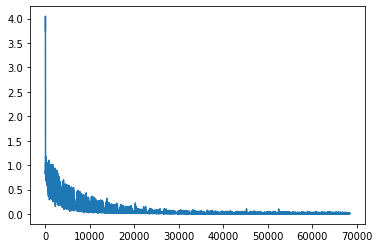

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(allLoss)


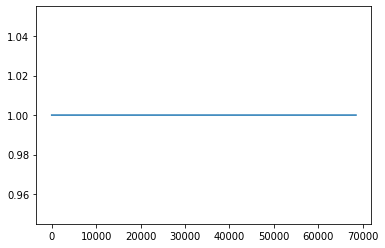

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(simVec)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(simVec)

In [ ]:
print("\n\t allLoss:",allLoss)
print("\n\t simVec:",simVec)


In [ ]:
len(labels['phocnet'])
#labels.keys()

In [ ]:
'''
    testing part
'''

In [1]:
import argparse
import itertools
import numpy as np
from numpy import linalg as LA
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt

from tensorflow_addons.layers import SpatialPyramidPooling2D
from phos_label_generator import gen_label


2022-02-07 15:25:04.235264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/k/anaconda3/envs/tf_gpu3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [12]:
import os
'''
ap = argparse.ArgumentParser()
ap.add_argument("-model", type=str,required=False,
	help="Pretrained Model")
ap.add_argument("-test", type=str,required=True,
	help="Folder having unseen words")
ap.add_argument("-mp", type=str,required=True,
	help="CSV file for Test Images to Class Label map")
ap.add_argument("-stf", type=str,default=None,required=False,
	help="Folder for seen Words (Gen. ZSl Setting)")
ap.add_argument("-smap", type=str,default=None,required=False,
	help="CSV file for Seen Images to Class Label map (Gen. ZSL Setting)")
ap.add_argument("-train", type=str,default=None,required=False,
	help="CSV file for Train Images to Class Label map (Gen. ZSL Setting)")
ap.add_argument("-idn", type=str,required=False, default='',
	help="Identifier for saving image files")
args = vars(ap.parse_args())
'''
model="new_IAM_16_"
test="./data/IAM_Data/IAM_test/"
mp="./data/IAM_Data/IAM_test_unseen.csv"
train="./data/IAM_Data/IAM_train.csv" 
idn="IAM_test_result_6_feb"


'''
python test_phoscnet.py 
-model new_IAM_16_ -test ./data/IAM_Data/IAM_test -mp ./data/IAM_Data/IAM_test_unseen.csv -train "./data/IAM_Data/IAM_train.csv" -idn "IAM_test_result_6_feb"


'''

'\npython test_phoscnet.py \n-model new_IAM_16_ -test ./data/IAM_Data/IAM_test -mp ./data/IAM_Data/IAM_test_unseen.csv -train "./data/IAM_Data/IAM_train.csv" -idn "IAM_test_result_6_feb"\n\n\n'

In [16]:
# Input: Two vectors x and y
# Output: Similarity index = Cosine simialirity * 1000

def similarity(x,y):
    return 1000*np.dot(x,y)/(LA.norm(x)*LA.norm(y))


# Input: Confusion matrix, true and predicted class names, plot title, color map and normalization parameter(bool)
# Output: Plots and saves confusion matrix 

def plot_confusion_matrix(cm,target_names_true,target_names_pred,title='Confusion matrix',cmap=None,normalize=True):
    #accuracy = np.trace(cm) / float(np.sum(cm))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm * 100
    cm[np.isnan(cm)] = 0
    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks_true = np.arange(len(target_names_true))
    tick_marks_pred = np.arange(len(target_names_pred))
    plt.xticks(tick_marks_pred, target_names_pred)
    plt.yticks(tick_marks_true, target_names_true)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Word Class Label Length')
    plt.savefig("Test_Plots/"+title+".png")
    plt.xlabel('Predicted Word Class Label Length')
    plt.show()

# Input: Model, dataframes for test set samples, dictionary for test set words and label(PHOC vector)
# Output: Similarity index = Cosine simialirity * 1000

def accuracy_test(model,df_test,test_word_label,name):
    cnt=0
    no_of_images=len(df_test)
    acc_by_len=dict()
    word_count_by_len=dict()
    for k in df_test['Word'].tolist():
        acc_by_len[len(k)]=0
        word_count_by_len[len(k)]=0
    lengths_true=sorted(acc_by_len.keys())
    lengths_pred=list(set(len(x) for x in test_word_label))
    l=len(lengths_true)
    m=len(lengths_pred)
    idx_true=dict()
    idx_pred=dict()
    for k in range(l):
        idx_true[lengths_true[k]]=k
    for k in range(m):
        idx_pred[lengths_pred[k]]=k
    conf_matrix=np.zeros(shape=(l,m))
    Predictions=[]

	# Finding predictions for test set word images

    for i in range(len(df_test)):
        x=img_to_array(load_img(df_test['Image'].iloc[i]))
        word=df_test['Word'].iloc[i]
        word_count_by_len[len(word)]+=1
        x = np.expand_dims(x, axis=0)
        print("\n\t prediction:",model.predict(x))
        
        y_pred=np.squeeze(model.predict(x))
        mx=0
        for k in test_word_label:
            temp=similarity(y_pred,test_word_label[k])
            if temp>mx:
                mx=temp
                op=k
        conf_matrix[idx_true[len(word)]][idx_pred[len(op)]]+=1
        Predictions.append((df_test['Image'].iloc[i],word,op))
        if op==word:
            cnt+=1
            acc_by_len[len(word)]+=1
    for k in acc_by_len:
        if acc_by_len[k]!=0:
            acc_by_len[k]=acc_by_len[k]/word_count_by_len[k] * 100
	
	# Storing true and predicted labels for each image sample

    df=pd.DataFrame(Predictions,columns=["Image","True Label","Predicted Label"])
    df.set_index('Image', inplace=True)
    df.to_csv("Test_Results/"+name+".csv")
    print("Correct predictions:",cnt,"   Accuracy=",cnt/no_of_images)

	# Plotting length-wise correct predictions 

    plt.figure(figsize=(10,6))
    plt.bar(*zip(*acc_by_len.items()))
    plt.title('Acc:'+str(cnt)+'/'+str(no_of_images)+'  Correct predictions lengthwise')
    plt.xticks(lengths_true)
    plt.xlabel('Word Length')
    plt.ylabel('Percentage of correct predictions')
    plt.savefig("Test_Plots/"+name+"_ZSL_acc.png")
    plt.show()

	# Plotting length-wise confusion matrix
    plot_confusion_matrix(conf_matrix,lengths_true,lengths_pred,title=name+"_confmat")
    return cnt/no_of_images

# Input: model, folder names for samples, CSV files having sample to label mapping(Train and test set), and name(identifier in plot names)
# Output: Prediction accuracy (Also calls functions for plotting)

def zsl_test(model,test_folder,test_csv_file,seen_word_folder,seen_word_map,train_csv_file,name):
    df_test=pd.read_csv(test_csv_file)
    print("\n\t df:",df_test.shape)
    test_word_label=gen_label(list(set(df_test['Word'])))
    df_test['Image']=test_folder+"/"+df_test['Image']
    acc_unseen=accuracy_test(model, df_test, test_word_label, name+"_conv")
    print("Conventional ZSL Accuracy = ", acc_unseen)

    if seen_word_folder!=None and train_csv_file!=None:
        df_train=pd.read_csv(seen_word_map)
        df_lex=pd.read_csv(train_csv_file)
        train_word_label=gen_label(list(set(df_lex['Word'])))
        df_train['Image']=seen_word_folder+"/"+df_train['Image']
        test_word_label={**test_word_label,**train_word_label}
        acc_unseen=accuracy_test(model, df_test, test_word_label, name+"_gen_unseen")
        acc_seen=accuracy_test(model, df_train, test_word_label, name+"_gen_seen")
        print("Accuracy with Unseen Words = ", acc_unseen)
        print("Accuracy with Seen Words = ", acc_seen)
        gen_zsl_acc=2*acc_unseen*acc_seen/(acc_unseen+acc_seen)
        print("Generalized ZSL Accuracy = ",gen_zsl_acc)



MODEL=model#args['model']
test_folder=test#args['test']
test_map=mp#args['mp']
seen_word_map=None#args['smap']
seen_words_folder=None#args['stf']
train_map="./data/IAM_Data/IAM_train.csv" #args['train']
name="_"+str(idn)

'''
python test_phoscnet.py 
-model new_IAM_16_ -test ./data/IAM_Data/IAM_test -mp ./data/IAM_Data/IAM_test_unseen.csv -train "./data/IAM_Data/IAM_train.csv" -idn "IAM_test_result_6_feb"

'''

# Create directories for storing test results and plots

if not os.path.exists("Test_Plots"):
    os.makedirs("Test_Plots")
if not os.path.exists("Test_Results"):
    os.makedirs("Test_Results")

# Load model from filename and print model name(if successfully loaded)
modelLoad=tf.keras.models.load_model(model+".h5")
print(MODEL)

# Function called for test set prediction and result plotting
zsl_test(modelLoad,test_folder,test_map,seen_words_folder,seen_word_map,train_map,name)



new_IAM_16_

	 df: (1341, 3)

	 prediction: [array([[8.58179092e-01, 1.05048347e+00, 3.99104738e+00, 0.00000000e+00,
        2.29740238e+00, 0.00000000e+00, 2.40819359e+00, 4.60870457e+00,
        7.39086121e-02, 1.37319565e-02, 1.04130602e+00, 0.00000000e+00,
        8.77113342e-01, 1.43941975e+00, 0.00000000e+00, 1.41452014e+00,
        0.00000000e+00, 1.49596381e+00, 2.58551264e+00, 0.00000000e+00,
        0.00000000e+00, 2.66027972e-02, 1.06537771e+00, 5.40353358e-04,
        2.60238600e+00, 0.00000000e+00, 1.05008948e+00, 0.00000000e+00,
        1.03982067e+00, 2.07255125e+00, 0.00000000e+00, 0.00000000e+00,
        9.44904149e-01, 0.00000000e+00, 3.44725370e-01, 1.35176182e+00,
        0.00000000e+00, 9.97711301e-01, 0.00000000e+00, 9.54248965e-01,
        1.15838099e+00, 0.00000000e+00, 0.00000000e+00, 9.14400294e-02,
        0.00000000e+00, 6.40223563e-01, 3.80089909e-01, 0.00000000e+00,
        7.74863601e-01, 0.00000000e+00, 7.21946836e-01, 1.98696136e+00,
        0.00000000e

/home/k/anaconda3/envs/tf_gpu3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: could not broadcast input array from shape (165,) into shape (1,)

In [15]:
modelLoad=tf.keras.models.load_model(model+".h5")
print(modelLoad.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________